## Distribution of editing efficiency

### PRIDICT

The dataset of pridict-1 has 90k examples, the example suggests using a zero inflated poisson or gaussian distribution

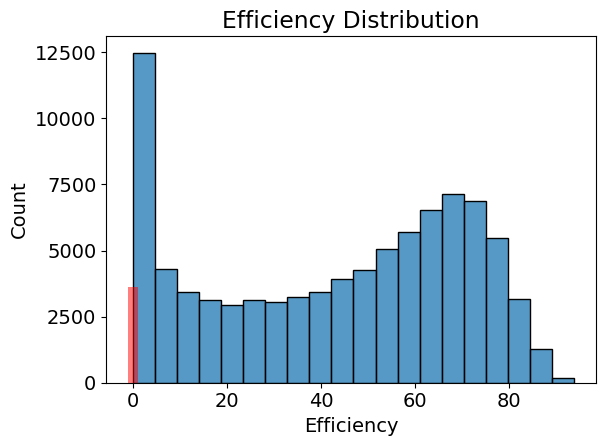

In [4]:
from os.path import join as pjoin

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
path = pjoin('data', 'pridict-90k.csv')
df = pd.read_csv(path)

efficiency_col = 'averageedited'
df = df[df[efficiency_col].notnull()]


# list out zero efficiency as a separate group
zero_efficiency = df[df[efficiency_col] == 0]
non_zero_efficiency = df[df[efficiency_col] > 0]

# plot the distribution of efficiency
fig, ax = plt.subplots()
sns.histplot(non_zero_efficiency[efficiency_col], bins=20, ax=ax)
ax.set_xlabel('Efficiency')
ax.set_ylabel('Count')
ax.set_title('Efficiency Distribution')

# true zero is a separate bar
ax.bar(0, len(zero_efficiency), color='red', alpha=0.5, width=2)

# increase font size everywhere
plt.rcParams.update({'font.size': 18})

# tight layout
plt.tight_layout()

# save the figure
fig.savefig(pjoin('txt', 'figures', 'efficiency_distribution.png'))

In [10]:
# correlation between deepcas9 score and predicted efficiency
from scipy.stats import pearsonr, spearmanr
import numpy as np

# Load the data
path = pjoin('data', 'pridict-90k.csv')
df = pd.read_csv(path)

spcas9 = df['deepcas9'].values
efficiency = df['averageedited'].values

print(np.corrcoef(spcas9, efficiency))

[[1.         0.20718284]
 [0.20718284 1.        ]]


In [5]:
# acquire a subset of the pridict 90k dataset
from os.path import join as pjoin

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
path = pjoin('data', 'pridict-90k.csv')
df = pd.read_csv(path)

efficiency_col = 'averageedited'
df = df[df[efficiency_col].notnull()]

# rename name column to HGVS
df.rename(columns={'Name': 'HGVS'}, inplace=True)

# get 1000 random samples and save a pridict-90k-small.csv
df.sample(1000).to_csv(pjoin('data', 'pridict-90k-small.csv'), index=False)

# Data Parsing

## HGVS to hg38 coordinates

In [2]:
from dataset import parse_hgvs
from os.path import join as pjoin
import pandas as pd

# load the small dataset
path = pjoin('data', 'pridict-90k-small.csv')

df = pd.read_csv(path)
df = parse_hgvs(df)

print(df.head())

100%|██████████| 2/2 [00:07<00:00,  3.69s/it]

   averageedited  averageunedited  averageindel  \
0      61.037202        15.624968     23.337831   
1      75.728608        21.184532      3.086859   
2      62.291955        14.233247     23.474798   
3      73.368779        12.469879     14.161342   
4       2.869652        92.088859      5.041489   

                                              HGVS   Gene  \
0           NM_000157.4(GBA):c.630del (p.Val211fs)    GBA   
1           NM_178152.3(DCX):c.266G>C (p.Arg89Pro)    DCX   
2        NM_000527.4(LDLR):c.1786A>T (p.Lys596Ter)   LDLR   
3       NM_000135.4(FANCA):c.3558dup (p.Arg1187fs)  FANCA   
4  NM_006920.6(SCN1A):c.3769_3779del (p.Leu1257fs)  SCN1A   

                                           Phenotype  PBSlength  \
0                                    Gaucher disease         13   
1                                        Heterotopia         13   
2                      Familial hypercholesterolemia         13   
3  Fanconi anemia;Fanconi anemia, complementation...      

: 

## Gene to Strand

In [14]:
from dataset import parse_hgvs
from os.path import join as pjoin
import pandas as pd
from pyensembl import EnsemblRelease

ensembls = [EnsemblRelease(111)]

# load the small dataset
path = pjoin('data', 'pridict-90k-small.csv')
data = pd.read_csv(path)

# add coordinates of the edit
data = parse_hgvs(data)

genes = data['Gene'].tolist()
strand = []

for gene in genes:
    i = 0
    gene_data = None
    while i < len(ensembls):
        ensembl = ensembls[i]
        try:
            gene_data = ensembl.genes_by_name(gene)[0]
            # print("Gene:", gene.name)
            # print("Location:", gene.contig, gene.start, "-", gene.end)
            # print("Strand:", "Forward" if gene.strand == 1 else "Reverse")
            break
        except:
            i += 1
    if gene_data is not None:
        strand.append("Fw" if gene_data.strand == 1 else "Rv")
    else:
        print(f"{gene} not found")
        strand.append(None)

target_strand = data['Target_Strand'].tolist()
# remove the "'" from the strand
target_strand = [s.replace("'", '') for s in target_strand]

# add a strand column to the dataset
# if target strand matches the gene strand, it is a sense edit
data['strand'] = ['+' if str(s) == str(t) else '-' for s, t in zip(strand, target_strand)]
# remove rows where strand is None
data = data[[s is not None for s in strand]]

print(data.head())

# use the forward or reverse of the target strand and the Editing_Position column to identify the gRNA binding region
# the 23 bp long regions are marked with start and end columns, inclusive
data['start'] = data['pos'] - data['Editing_Position'] - data['PBSlength'] + 1 if strand == 'Fw' else data['pos'] + data['Editing_Position'] + data['PBSlength'] - 22
data['end'] = data['start'] + 22

data['target_sequence'] = data['wide_initial_target'].str.slice(10, 33)

100%|██████████| 1/1 [00:01<00:00,  1.35s/it]

   averageedited  averageunedited  averageindel  \
0      17.184357        81.528725      1.286918   
1       0.031358        98.626012      1.342630   
2      42.450889        49.839235      7.709876   
3      45.304817        26.826022     27.869160   
4      53.442665        32.004582     14.552753   

                                              HGVS      Gene  \
0                        NR_001566.1(TERC):n.79del      TERC   
1  NM_016953.4(PDE11A):c.2268_2272del (p.Ser757fs)    PDE11A   
2     NM_000488.3(SERPINC1):c.500A>C (p.Asn167Thr)  SERPINC1   
3       NM_080679.2(COL11A2):c.109G>T (p.Ala37Ser)   COL11A2   
4         NM_000046.5(ARSB):c.454C>T (p.Arg152Trp)      ARSB   

                                           Phenotype  PBSlength  \
0          Dyskeratosis congenita autosomal dominant         13   
1  Pigmented nodular adrenocortical disease, prim...         13   
2                  Reduced antithrombin III activity         13   
3  Deafness, autosomal recessive 53;Nons

: 

## Full pipeline

In [ ]:
from dataset import convert_pridict_to_crispai
from os.path import join as pjoin
import pandas as pd

# load the small dataset
path = pjoin('data', 'pridict-90k-small.csv')
og_data = pd.read_csv(path)

data = convert_pridict_to_crispai(og_data)

# save to the data folder
data.to_csv(pjoin('data', 'crispai-90k-small.csv'), index=False)

# remove entries with no matching uniqueindex from pridict-90k-small


/home/peiheng/anaconda3/envs/dl/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some genebe annotations are missing
[72, 72, 72, 72, 70, 72, 72, 70, 70, 72, 72, 71, 71, 71, 72, 72, 70, 74, 71, 72, 72, 72, 72, 72, 70, 72, 72, 70, 72, 72, 72, 72, 70, 70, 72, 70, 72, 72, 72, 70, 72, 71, 71, 72, 70, 72, 71, 72, 70, 72, 70, 70, 72, 72, 72, 70, 71, 69, 72, 73, 72, 70, 70, 72, 72, 71, 71, 70, 72, 70, 72, 72, 72, 72, 71, 72, 70, 70, 72, 71, 72, 72, 70, 72, 70, 70, 70, 72, 70, 70, 75, 70, 71, 71, 72, 72, 70, 70, 75, 71, 71, 70, 72, 70, 70, 70, 70, 72, 70, 70, 70, 72, 72, 72, 70, 70, 71, 79, 72, 75, 73, 71, 72, 70, 70, 72, 70, 72, 72, 71, 72, 70, 70, 71, 70, 70, 72, 72, 70, 72, 70, -1, 70, 72, 72, 72, 72, 70, 72, 70, 72, 72, 72, 74, 67, 73, 72, 72, 72, 70, 70, 72, 72, 72, 70, 72, 72, 71, 72, 72, 70, 72, 72, 73, 72, 72, 70, 72, 72, 70, 72, 72, 70, 70, 72, 71, 70, 70, 72, 72, 72, 72, 70, 70, 71, 71, 72, 72, 72, 72, 70, 72, 72, 71, 70, 72, 70, -1, 72, 70, 72, 70, 71, 70, 72, 70, 71, 70, 70, 72, 72, 71, 70, 71, 71, 72, 70, 72, 72, 71, 74, 72, 70, 72, 72, 72, 72, 70, 70, 72, 72,

In [1]:
# execute for the full dataset
from dataset import convert_pridict_to_crispai
from os.path import join as pjoin
import pandas as pd

# load the small dataset
path = pjoin('data', 'pridict-90k.csv')
data = pd.read_csv(path)

data = convert_pridict_to_crispai(data, mode='long')

# save to the data folder
data.to_csv(pjoin('data', 'crispai-90k-long.csv'), index=False)

/home/peiheng/anaconda3/envs/dl/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some genebe annotations are missing
[72, 72, 72, 72, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 70, 70, 70, 70, 110, 110, 110, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 110, 110, 110, 110, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 110, 110, 110, 110, 70, 70, 70, 70, 71, 71, 71, 71, 110, 110, 110, 110, 110, 110, 110, 110, 70, 70, 70, 70, 70, 70, 110, 110, 110, 110, 70, 70, 110, 110, 110, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 110, 110, 70, 70, 70, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 70, 70, 70, 70, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 70, 70, 70, 70, 70, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 11

# Verify the Output

In [ ]:
import pandas as pd

# make sure sgRNA_sequence is contained in the context sequence flank_73 sequence
data = pd.read_csv('data/crispai-90k.csv')

data['sgRNA_sequence'] = data['sgRNA_sequence'].str.slice(0, 19)

sgRNA_in_context = [sgRNA in context for sgRNA, context in zip(data['sgRNA_sequence'], data['context sequence flank_73'])]

print(f'{sum(sgRNA_in_context)} out of {len(data)} sgRNAs are in the context sequence')

def complement(sequence):
    complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'}
    return ''.join([complement[base] for base in sequence])

# check if the complementary sequence of sgRNA is in context
comp_sgRNA_in_context = [complement(sgRNA) in context for sgRNA, context in zip(data['sgRNA_sequence'], data['context sequence flank_73'])]

print(f'{sum(comp_sgRNA_in_context)} out of {len(data)} sgRNAs are in the context sequence when considering the complement')

# reverse the order of the sgRNA sequence and check if it is in the context sequence
sgRNA_inversed_in_context = [sgRNA[::-1] in context for sgRNA, context in zip(data['sgRNA_sequence'], data['context sequence flank_73'])]

print(f'{sum(sgRNA_inversed_in_context)} out of {len(data)} sgRNAs are in the context sequence when considering the reverse order')

# check the complement of the inverse sgRNA in the context sequence
comp_sgRNA_inversed_in_context = [complement(sgRNA[::-1]) in context for sgRNA, context in zip(data['sgRNA_sequence'], data['context sequence flank_73'])]

print(f'{sum(comp_sgRNA_inversed_in_context)} out of {len(data)} reverse complement sgRNAs are in the context sequence')

import regex

def find_all(string, substring):
    start = 0
    indices = []

    while start < len(string):
        start = string.find(substring, start)
        if start == -1:
            break
        indices.append(start)
        start += 1
    
    return indices

# locate the sgRNA in the context sequence
sgRNA_positions = [find_all(context, sgRNA) for sgRNA, context in zip(data['sgRNA_sequence'], data['context sequence flank_73'])]

print(sgRNA_positions)

# remove data where sgRNA is not at position 73 in the context sequence
print(f"{len(data)} before filtering")
data = data[[len(pos) > 0 and pos[0] == 73 for pos in sgRNA_positions]]
print(f"{len(data)} after filtering")

# save the filtered data
data.to_csv('data/crispai-90k-filtered-long.csv', index=False)

91152 out of 92366 sgRNAs are in the context sequence
0 out of 92366 sgRNAs are in the context sequence when considering the complement
0 out of 92366 sgRNAs are in the context sequence when considering the reverse order
0 out of 92366 reverse complement sgRNAs are in the context sequence
[[73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [

## Performance Analysis

In [4]:
# join the filtered pridict-90k dataset with the crispAI predictions on unique index
import pandas as pd
from os.path import join as pjoin

# load the filtered dataset
path = pjoin('data', 'crispai-90k-filtered.csv')
data = pd.read_csv(path)

# load the crispAI predictions
path = pjoin('data', 'crispai-predictions.csv')
predictions = pd.read_csv(path)

# join the datasets
data = data.merge(predictions, on='uniqueindex')

# for each fold, calculate the average efficiency
for fold in range(5):
    fold_data = data[data['uniqueindex'] % 5 == fold]
    # calculate pearson correlation between the predicted_efficiency and the averageedited columns
    correlation = fold_data['predicted_efficiency'].corr(fold_data['efficiency'])
    # calculate spearman correlation
    spearman_correlation = fold_data['predicted_efficiency'].corr(fold_data['efficiency'], method='spearman')
    print(f"Fold {fold}: Pearson: {correlation}, Spearman: {spearman_correlation}")


Fold 0: Pearson: 0.4528138025536973, Spearman: 0.37434807720034136
Fold 1: Pearson: 0.46004561327560206, Spearman: 0.38334002038783166
Fold 2: Pearson: 0.4101136789440776, Spearman: 0.3378558695638324
Fold 3: Pearson: 0.43882264257132353, Spearman: 0.3730424807515006
Fold 4: Pearson: 0.4533143289847503, Spearman: 0.3891194812097306
